### Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as tfk
from tensorflow.keras import mixed_precision

from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.model_selection import KFold
import zipfile

In [4]:
import os
import zipfile
from datetime import datetime
from os.path import basename

In [5]:
# Setup Mixed Precision

# Detect TPY
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else:
  policyConfig = 'mixed_float16'

policy = tf.keras.mixed_precision.Policy(policyConfig)
# tf.keras.mixed_precision.set_global_policy(policy)

### Load and process the (augmented) dataset

In [6]:
file_path = 'augmented_data.npz'
loaded_data = np.load(file_path, allow_pickle = True)

# Access the 'data' and 'labels' arrays
X = loaded_data['data']
labels = loaded_data['labels']

print(len(X))
print(len(labels))

X = X / 255.0

healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(X):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

np.random.shuffle(healthy)
np.random.shuffle(unhealthy)
# ChatGPT suggests to shuffle images to avoid batches containing the same images

print(len(healthy))
print(len(unhealthy))

13450
13450
6660
6790


In [7]:
# Codifica delle etichette 'healthy' e 'unhealthy' in numeri
label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]) # 0 è [1,0]

# Convert labels to one-hot encoding format
y = keras.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=seed, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=seed, test_size=0.3, stratify=y_temp)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


X_train shape: (9415, 96, 96, 3), y_train shape: (9415, 2)
X_val shape: (2824, 96, 96, 3), y_val shape: (2824, 2)


In [8]:
# Reshape arrays if necessary (replace (96, 96, 3) with the actual shape of your images)
X_train = X_train.reshape((len(X_train), -1))
X_val = X_val.reshape((len(X_val), -1))

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

#Apply SMOTE to the training val
X_val, y_val = smote.fit_resample(X_val, y_val)

# Reshape arrays back to the original shape
X_train = X_train.reshape((len(X_train), 96, 96, 3))
X_val = X_val.reshape((len(X_val), 96, 96, 3))

# Convert labels to one-hot encoding format
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (9506, 96, 96, 3), y_train shape: (9506, 2)
X_val shape: (2852, 96, 96, 3), y_val shape: (2852, 2)


In [9]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 2000

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

Input Shape: (96, 96, 3), Output Shape: (2,), Batch Size: 32, Epochs: 2000


### Setup the model

In [10]:
# Macs with Apple Silicon suffer performance penalties when using the modern Adam optimizer
# Detect system specs and select the appropriate optimizer

if platform.system() == "Darwin" and platform.processor() == "arm":
    optimizer = tf.keras.optimizers.legacy.Adam()
else:
    optimizer = tf.keras.optimizers.Adam()

In [11]:
# Load the VGG16 model pre-trained on ImageNet data
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the weights of the VGG16 model
vgg16.trainable = False

# Create a new model on top of the VGG16 model
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5
model.add(Dense(2, activation='sigmoid'))  # Binary classification, so use a sigmoid activation

# Compile the model
model.compile(loss=tf.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 15895106 (60.64 MB)
Trainable params: 1180418 (4.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Train the model

In [12]:
tl_history = model.fit(
    x=preprocess_input(X_train * 255),
    y=y_train,
    batch_size=128,
    epochs=epochs,
    validation_data=(preprocess_input(X_val * 255), y_val),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
).history

Epoch 1/2000
75/75 [==============================] - 13s 163ms/step - loss: 1.5524 - accuracy: 0.5988 - val_loss: 0.5994 - val_accuracy: 0.7237
Epoch 2/2000
75/75 [==============================] - 11s 154ms/step - loss: 0.9757 - accuracy: 0.6783 - val_loss: 0.5091 - val_accuracy: 0.7689
Epoch 3/2000
75/75 [==============================] - 12s 154ms/step - loss: 0.6491 - accuracy: 0.7464 - val_loss: 0.4698 - val_accuracy: 0.7837
Epoch 4/2000
75/75 [==============================] - 12s 154ms/step - loss: 0.5245 - accuracy: 0.7771 - val_loss: 0.4670 - val_accuracy: 0.7917
Epoch 5/2000
75/75 [==============================] - 12s 154ms/step - loss: 0.4656 - accuracy: 0.7982 - val_loss: 0.4743 - val_accuracy: 0.7861
Epoch 6/2000
75/75 [==============================] - 11s 153ms/step - loss: 0.4177 - accuracy: 0.8201 - val_loss: 0.4217 - val_accuracy: 0.8135
Epoch 7/2000
75/75 [==============================] - 11s 153ms/step - loss: 0.3971 - accuracy: 0.8295 - val_loss: 0.4128 - val_ac

In [13]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"model_{formatted_datetime}_TL.zip"
model.save(zipfile_name)

### Fine-Tuning

In [14]:
#Re-load the model after transfer learning
ft_model = keras.models.load_model(zipfile_name)
ft_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 15895106 (60.64 MB)
Trainable params: 1180418 (4.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [15]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [16]:
# Freeze first N layers, e.g., until the 150th one
N = 150
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout (Dropout)           (None, 256)              

In [17]:
# Compile the model
ft_model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics='accuracy')

In [18]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 128,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
75/75 [==============================] - 13s 164ms/step - loss: 0.5501 - accuracy: 0.8388 - val_loss: 0.7068 - val_accuracy: 0.8306
Epoch 2/200
75/75 [==============================] - 11s 153ms/step - loss: 0.2970 - accuracy: 0.8972 - val_loss: 0.6637 - val_accuracy: 0.8278
Epoch 3/200
75/75 [==============================] - 11s 153ms/step - loss: 0.2409 - accuracy: 0.9153 - val_loss: 0.6222 - val_accuracy: 0.8324
Epoch 4/200
75/75 [==============================] - 11s 153ms/step - loss: 0.2274 - accuracy: 0.9157 - val_loss: 0.6098 - val_accuracy: 0.8296
Epoch 5/200
75/75 [==============================] - 12s 161ms/step - loss: 0.1997 - accuracy: 0.9270 - val_loss: 0.6116 - val_accuracy: 0.8247
Epoch 6/200
75/75 [==============================] - 11s 152ms/step - loss: 0.2066 - accuracy: 0.9258 - val_loss: 0.5932 - val_accuracy: 0.8303
Epoch 7/200
75/75 [==============================] - 11s 152ms/step - loss: 0.1915 - accuracy: 0.9300 - val_loss: 0.6049 - val_accuracy:

In [19]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8365


In [20]:
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"model_{formatted_datetime}_FT.zip"
model.save(zipfile_name)

### Plot the training

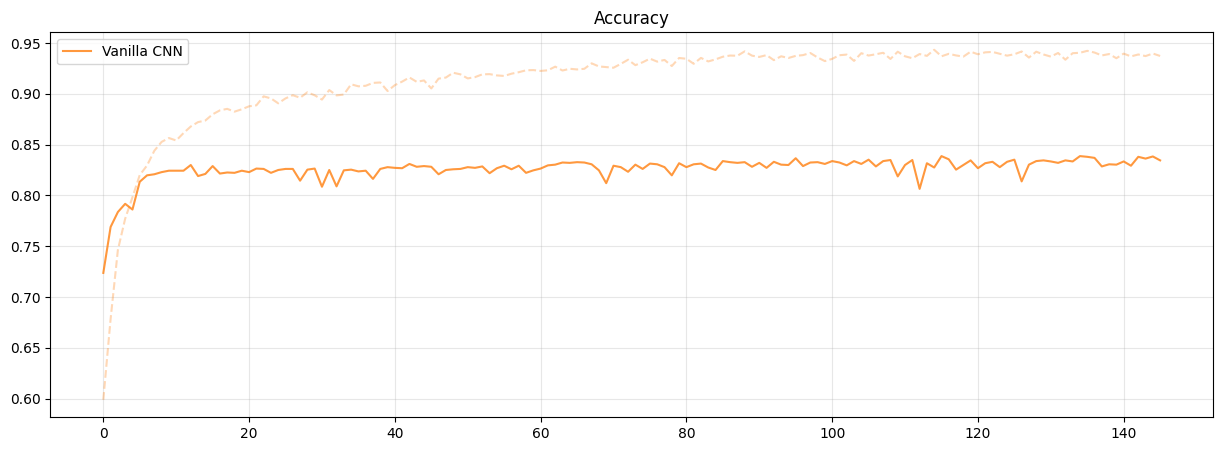

In [21]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Save the model and create submission(s)

In [22]:
# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        
        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        X = X/255.0
        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)  # Shape [BS]
        return out

""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)




SubmissionModel/SubmissionModel/fingerprint.pb
SubmissionModel/SubmissionModel/keras_metadata.pb
SubmissionModel/SubmissionModel/saved_model.pb
SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
SubmissionModel/SubmissionModel/variables/variables.index
SubmissionModel_20231117_201916.zip


In [23]:
# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        
        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        X = X/255.0
        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)  # Shape [BS]
        return out

""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}_withPreprocess.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)




SubmissionModel/SubmissionModel/fingerprint.pb
SubmissionModel/SubmissionModel/keras_metadata.pb
SubmissionModel/SubmissionModel/saved_model.pb
SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
SubmissionModel/SubmissionModel/variables/variables.index
SubmissionModel_20231117_201916_withPreprocess.zip
